In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [2]:
locs = np.genfromtxt('locs.txt')
l0 = locs[int(np.floor(len(locs)/2)+1), 0]
l1 = locs[int(np.floor(len(locs)/2)), 1]
l2 = locs[int(np.floor(len(locs)/2)), 2]
l3 = locs[int(np.floor(len(locs)/2)-1), 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [3]:
sel = [(ff < l1+.6*dnu) & (ff > l1-2*d02)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


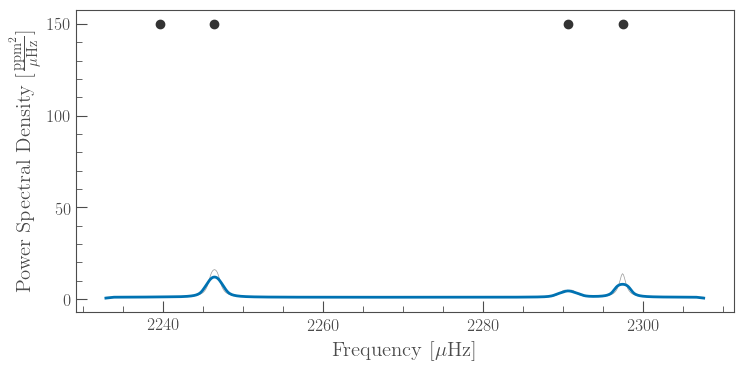

In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter([l0,l1,l2,l3],[150,150,150,150])

In [5]:
import pystan
model = '''
functions{
    real get_epsilon(real i, int l, int m){
        if (l == 0){
            return 1.;
        }
        else if (l == 1){
           if (m == 0){
               return cos(i)^2;
           }
           else if (abs(m) == 1){
               return 0.5 * sin(i)^2;
           }
           else return 1.;
        }
        else if (l == 2){
            if (m == 0){
                return 0.25 * (3. * (i)^2 - 1.)^2;
            }
            else if (abs(m) == 1){
                return (3./8.)*sin(2*i)^2;
            }
            else if (abs(m) == 2){
                return (3./8.) * sin(i)^4;
            }
            else return 1.;
        }
        else if (l == 3){
            if (m == 0){
                return (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
            }
            else if (abs(m) == 1){
                return (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
            }
            else if (abs(m) == 2){
                return (15./8.) * cos(i)^2 * sin(i)^4;
            }
            else if (abs(m) == 3){
                return (5./16.)*sin(i)^6;
            }
            else return 1.;
        }
        else return 1.;
    }
    
    real get_Vl(int l){
        if (l==0){
            return 1.0;
        }
        else if (l==1){
            return 1.22;
        }
        else if (l==2){
            return 0.71;
        }
        else if (l==3){
            return 0.14;
        }
        else return 1.;
    }
    
    real lorentzian(real loc, int l, int m, real f, real i, real H, real w, real nus){
        return (get_epsilon(i, l, m) * get_Vl(l) * H) ./ (1 + (4/w^2) * (f - loc + m*nus)^2);
    }

    real[] multiplet(int N, real[] locs, real[] f, real i, real H, real w, real nus){
        real mod[N];
        mod = rep_array(1., N);
        
        for (l in 0:3){
            for (m in -l:l){
                for (n in 1:N){
                    mod[n] += lorentzian(locs[l+1], l, m, f[n], i, H, w, nus);
                }
            }
        }
        return mod;
    }

}
data{
    int N;
    real f[N];
    real i;
    real H;
    real w;
    real nus;
    real locs[4];
}
generated quantities{
    real lor[N];
    real mult[N];
       
    for (n in 1:N){
        lor[n] = lorentzian(0., 1, 0, f[n], i, H, w, nus);
    }    
    
    mult = multiplet(N, locs, f, i, H, w, nus);
}

'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_73260da69ade00e561dab46311d4695f NOW.


In [6]:
data = {'N':len(f),
        'locs':[l0,l1,l2,l3],
       'f':f,
       'i':np.deg2rad(56.),
       'H':14,
       'w':1.,
       'nus':0.411}

fit = sm.sampling(data=data, iter=1, chains=1,algorithm='Fixed_param')

- the for (m in -l:l) works great

- I can select from locs fine, by the looks of it

- We can generate a lorentzian

- When passing a real array to a function, pass as real[]

- You cant' raise vectors to a power, so need to use real[]

- Looks like I may have multiplet working

- Can't invert a real array, need to do it value by value as usual

In [7]:
m = fit['mult']

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


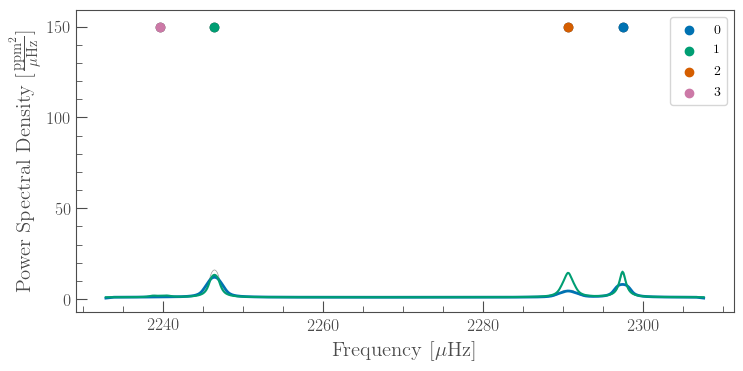

In [8]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
ax.scatter([l0,l1,l2,l3],[150,150,150,150])
ax.scatter(l0, 150, label=0)
ax.scatter(l1, 150, label=1)
ax.scatter(l2, 150, label=2)
ax.scatter(l3, 150, label=3)
ax.legend()
ax.plot(f, m.T, label='multiplet')
plt.show()